<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_10_real_time_noise_rejection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, SeparableConv1D, BatchNormalization

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This function is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model.

In [3]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import tensorflow as tf
######################################Calculate FLOPS##########################################
def get_flops(model):
    '''
    Calculate FLOPS
    Parameters
    ----------
    model : tf.keras.Model
        Model for calculating FLOPS.

    Returns
    -------
    flops.total_float_ops : int
        Calculated FLOPS for the model
    '''

    batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

Downloading the data (1 signal data file and 5 noise data files)

In [4]:
# download data file that contains signal events
if not os.path.exists("trimmed100_data_signal_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


In [ ]:
# download data file that contains noise events
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0000.npy"):
  !gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0001.npy"):
  !gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0002.npy"):
  !gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwzUqlhLRd
if not os.path.ezists("trimmed100_data_noise_3.6SNR_1ch_0003.npy"):
  !gdown https://drive.google.com/uc?id=1zoTjcJd762zUAP0I7Ukv0y2go6ZwTmIa
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0004.npy"):
  !gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
if not os.path.exists("trimmed100_data_noise_3.6SNR_1ch_0005.npy"):
  !gdown https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 222MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 255MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 248MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 250MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lX4M1t8W4zg0wVXA4HYUlnFGU3nMYPGx
To: /cont

Load the data into memory and combine it into one array.

In [7]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [8]:
# combine noise and signal data set
x = np.vstack((noise, signal))
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal.
y = np.ones(len(x))
y[:len(noise)] = 0

(599997, 100)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below.

In [9]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=int)
rng=np.random.default_rng(seed=95736)
rng.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]

# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


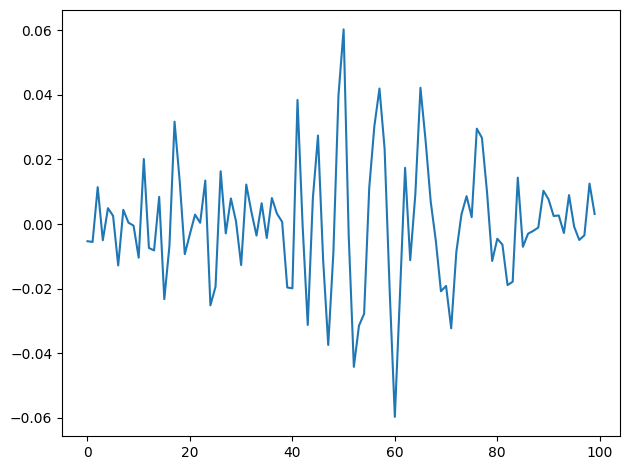

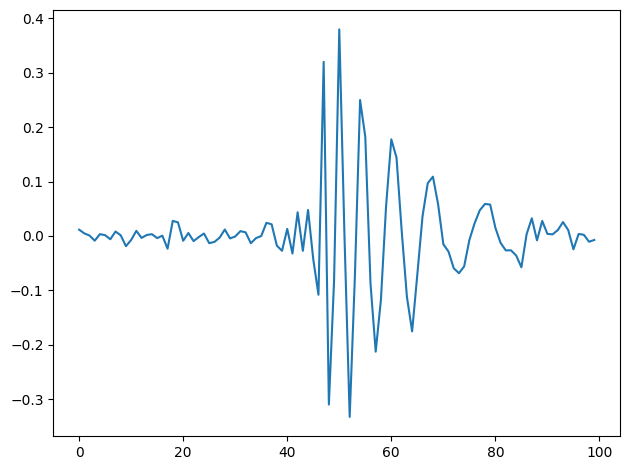

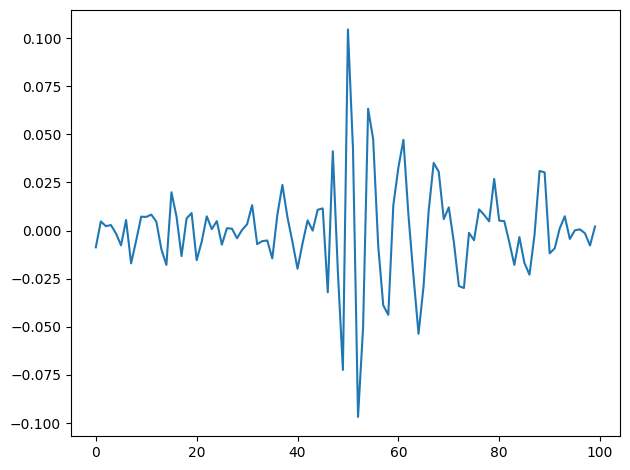

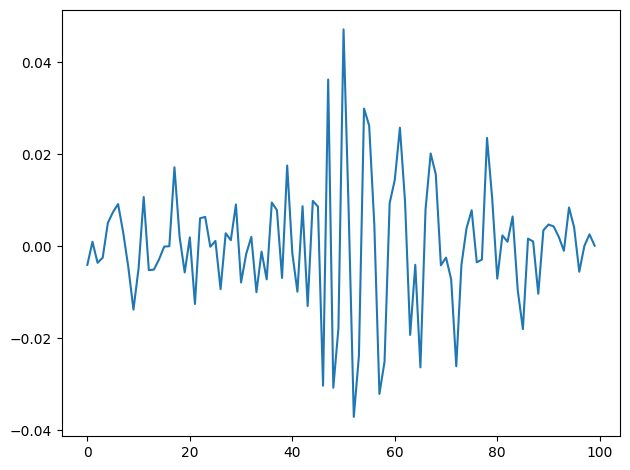

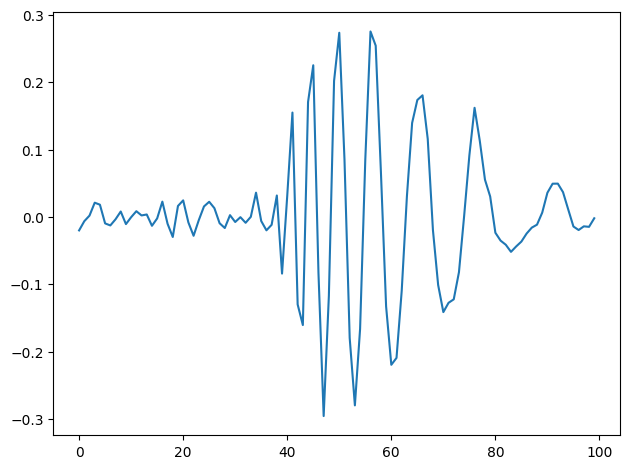

In [7]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

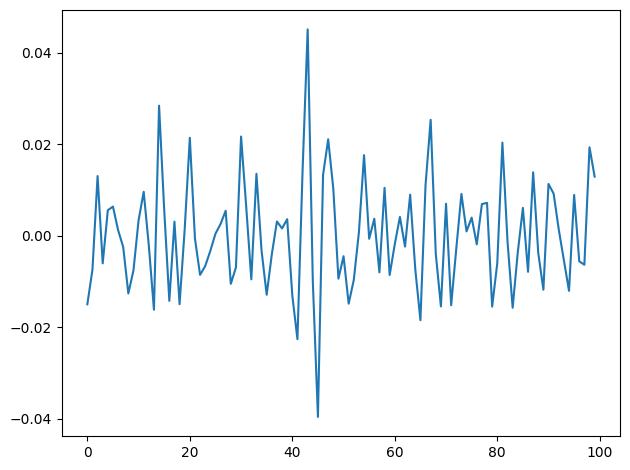

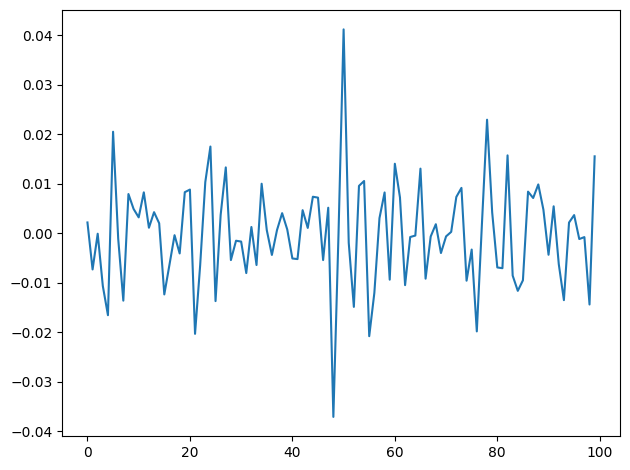

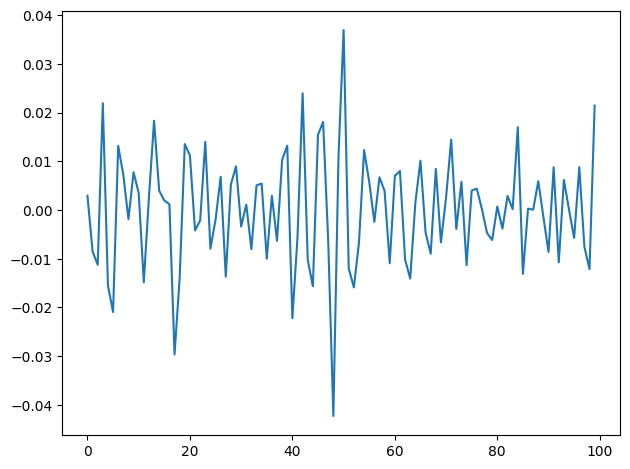

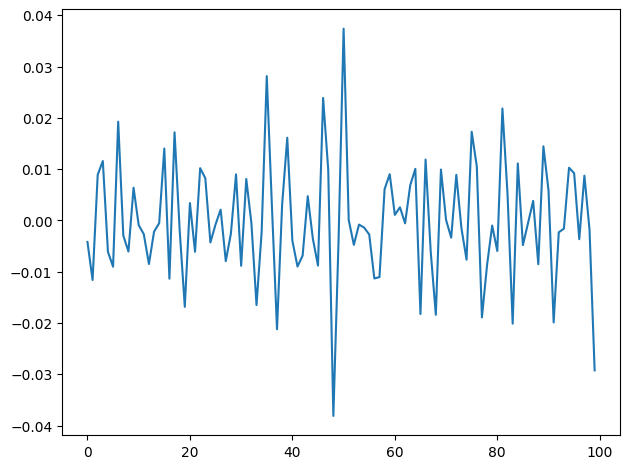

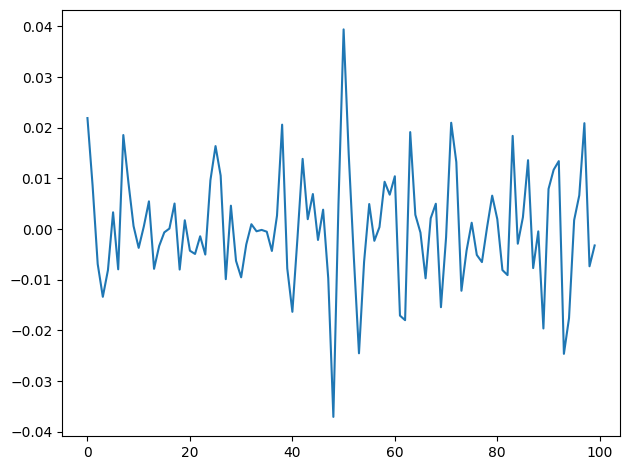

In [7]:
#Plot a few noise events
for trace in x[~smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace)
  fig.tight_layout()
  plt.show()

## Note
I have a hard time seeing the difference.

In [10]:
scaler=StandardScaler().fit(x)
x_scaled = scaler.transform(x)

x_scaled=np.expand_dims(x_scaled, axis=-1)

x_train, x_test, y_train, y_test=train_test_split(x_scaled, y, test_size=0.3)

In [11]:

input = keras.Input(shape=x_scaled.shape[1:])

z=SeparableConv1D(8, kernel_size=8, padding="same")(input)
z=BatchNormalization()(z)
z=Activation("relu")(z)
#z=layers.Dropout(0.2)(x)

z=SeparableConv1D(16, kernel_size=4, padding="same", strides=3)(z)
z=BatchNormalization()(z)
z=Activation("relu")(z)

z=SeparableConv1D(32, kernel_size=4, padding="same", strides=4)(z)
z=BatchNormalization()(z)
z=Activation("relu")(z)

z=Flatten()(z)

z=Dense(16, activation="relu")(z)
output=Dense(1, activation="sigmoid")(z)

model = keras.Model(input, output)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 separable_conv1d (Separable  (None, 100, 8)           24        
 Conv1D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 100, 8)           32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 8)            0         
                                                                 
 separable_conv1d_1 (Separab  (None, 34, 16)           176       
 leConv1D)                                                       
                                                             

In [12]:

model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.SpecificityAtSensitivity(0.9), keras.metrics.Recall()])

Require recall/sensitivity to be >90% and specificity to be >99.9%

In [41]:
#Define callbacks to save the best model during the training

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
c1=keras.callbacks.ReduceLROnPlateau(factor=0.90, patience=3, verbose=1, min_lr=1e-5),
c2=keras.callbacks.EarlyStopping(patience=8, verbose=1)
c3=keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
c4=keras.callbacks.CSVLogger("history_{}.csv".format(model.name))

#Note that this will scramble the data before training
results = model.fit(x_train, y_train,
    epochs=10,
    batch_size=2000,
    verbose=1,
    validation_split=0.5,
    shuffle=True,
    callbacks=[c1,c2, c3, c4])

Epoch 1/10
105/105 [==============================] - 12s 98ms/step - loss: 0.2265 - specificity_at_sensitivity_2: 0.7856 - recall_2: 0.5941 - val_loss: 0.2980 - val_specificity_at_sensitivity_2: 0.9989 - val_recall_2: 0.6112 - lr: 0.0010
Epoch 2/10
105/105 [==============================] - 8s 73ms/step - loss: 0.0499 - specificity_at_sensitivity_2: 0.9998 - recall_2: 0.9206 - val_loss: 0.1349 - val_specificity_at_sensitivity_2: 1.0000 - val_recall_2: 0.6625 - lr: 0.0010
Epoch 3/10
105/105 [==============================] - 8s 74ms/step - loss: 0.0328 - specificity_at_sensitivity_2: 0.9999 - recall_2: 0.9537 - val_loss: 0.1230 - val_specificity_at_sensitivity_2: 1.0000 - val_recall_2: 0.7626 - lr: 0.0010
Epoch 4/10
105/105 [==============================] - 8s 74ms/step - loss: 0.0284 - specificity_at_sensitivity_2: 1.0000 - recall_2: 0.9616 - val_loss: 0.0778 - val_specificity_at_sensitivity_2: 1.0000 - val_recall_2: 0.8583 - lr: 0.0010
Epoch 5/10
105/105 [===========================

Recall and specificity is well above the threshold on the validation set (96.99% and 100%)

Now we are done with this model so lets try it out on the **test set.** The result of this will not be used in the subsequent optimization so there's no risk of overfitting to the test set.

In [16]:
model.load_weights("best_model.keras")
prediction=model.predict(x_test, batch_size=1000)
prediction.shape

180/180 [==============================] - 3s 3ms/step


(180000, 1)

In [17]:
prediction=prediction[:,0]

The excercise is to plot is to plot Sensitivity vs Specificity. I assume they want me to plot for different thresholds (classify neutrino at output >= threshold).

In [25]:
thresholds = np.linspace(0.1, 1, 100)
sensitivities = []
specificities = []
for threshold in thresholds:
    predicted_classes = (prediction >= threshold).astype(int)  # Binary predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_classes).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    sensitivities.append(sensitivity)
    specificities.append(specificity)


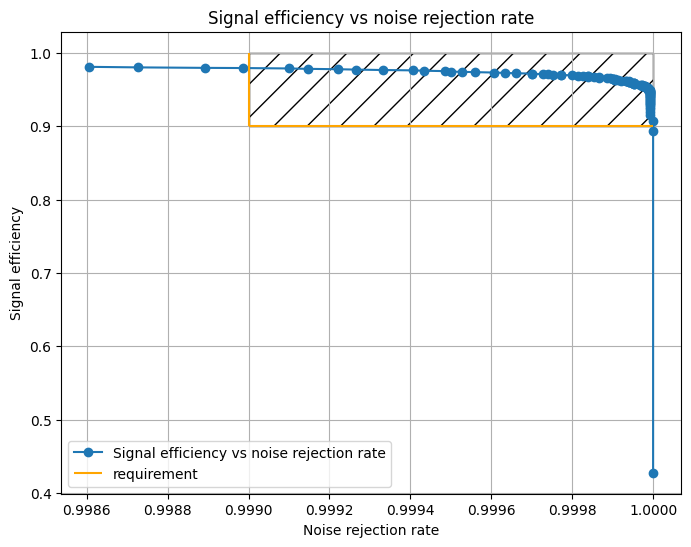

In [51]:

plt.figure(figsize=(8, 6))
plt.plot(specificities, sensitivities, marker='o', label='Signal efficiency vs noise rejection rate')
plt.hlines(0.9, 0.999, 1, colors="orange", label="requirement")
plt.vlines(0.999, 0.9, 1, colors="orange")
plt.fill_between([0.999, 1], [0.9, 0.9], [1,1], facecolor="none", hatch="/")
plt.ylabel('Signal efficiency')
plt.xlabel('Noise rejection rate')
plt.title('Signal efficiency vs noise rejection rate')
plt.grid(True)
plt.legend()
plt.show()

For some thresholds we are within the requirements. Now lets calculate the amount of floating point operations of the model

In [13]:
model.load_weights("best_model.keras")

In [14]:
flops=get_flops(model)
print(flops)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
37257


My hardware has ~6463 GFLOPS (gigaflops/second)

In [30]:
print(f"Calculation time is approximately {flops/(6463)} nanoseconds")

Calculation time is approximately 5.764660374439115 nanoseconds


Now we want to optimize design in terms of flops

In [120]:

input = keras.Input(shape=x_scaled.shape[1:])

z=SeparableConv1D(2, kernel_size=8, padding="same")(input)
z=BatchNormalization()(z)
z=Activation("relu")(z)

z=Flatten()(z)

output=Dense(1, activation="sigmoid")(z)

model = keras.Model(input, output)

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 100, 1)]          0         
                                                                 
 separable_conv1d_21 (Separa  (None, 100, 2)           12        
 bleConv1D)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 100, 2)           8         
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 100, 2)            0         
                                                                 
 flatten_16 (Flatten)        (None, 200)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 201

In [121]:
#Earlier we were way above the requirements and could just use the value for recall at threshold 0.5
#Since we're fine tuning now we want to be more specific and look for model which
#fulfills the requirement at some threshold
#In practice we switch Recall() to SensitivityAtSpecificity(0.999)
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.SpecificityAtSensitivity(0.9), keras.metrics.SensitivityAtSpecificity(0.999,  name="signal_efficiency")])

In [122]:
#Define callbacks to save the best model during the training
#Also be a bit more specific here and monitor sensitivity since the margins are slimmer

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
c1=keras.callbacks.ReduceLROnPlateau(factor=0.90, patience=3, verbose=1, min_lr=1e-5, monitor="val_signal_efficiency", mode="max"),
c2=keras.callbacks.EarlyStopping(patience=6, verbose=1, monitor="val_signal_efficiency", mode="max")
c3=keras.callbacks.ModelCheckpoint("best_model_optimized.keras", save_best_only=True, monitor="val_signal_efficiency", mode="max")
c4=keras.callbacks.CSVLogger("history_optimized_{}.csv".format(model.name))

#Note that this will scramble the data before training
results = model.fit(x_train, y_train,
    epochs=40,
    batch_size=1000,
    verbose=1,
    validation_split=0.5,
    shuffle=True,
    callbacks=[c1, c3, c4])

Epoch 1/40
210/210 [==============================] - 4s 14ms/step - loss: 0.4025 - specificity_at_sensitivity_15: 0.2778 - signal_efficiency: 0.1552 - val_loss: 0.3355 - val_specificity_at_sensitivity_15: 0.4107 - val_signal_efficiency: 0.3558 - lr: 0.0010
Epoch 2/40
210/210 [==============================] - 3s 12ms/step - loss: 0.2051 - specificity_at_sensitivity_15: 0.8266 - signal_efficiency: 0.6534 - val_loss: 0.1827 - val_specificity_at_sensitivity_15: 0.9326 - val_signal_efficiency: 0.7387 - lr: 0.0010
Epoch 3/40
210/210 [==============================] - 3s 12ms/step - loss: 0.1336 - specificity_at_sensitivity_15: 0.9803 - signal_efficiency: 0.8121 - val_loss: 0.1207 - val_specificity_at_sensitivity_15: 0.9905 - val_signal_efficiency: 0.8454 - lr: 0.0010
Epoch 4/40
210/210 [==============================] - 3s 12ms/step - loss: 0.1027 - specificity_at_sensitivity_15: 0.9941 - signal_efficiency: 0.8558 - val_loss: 0.0932 - val_specificity_at_sensitivity_15: 0.9974 - val_signal_

At the end we overfit but instead of early stopping only the best model is saved and further used. This best model fulfills the requiremnts with a margin. 

In [126]:
model.load_weights("best_model_optimized.keras")
prediction=model.predict(x_test, batch_size=1000)
prediction=prediction[:,0]

180/180 [==============================] - 0s 2ms/step


In [127]:
thresholds = np.linspace(0.1, 1, 100)
sensitivities = []
specificities = []
for threshold in thresholds:
    predicted_classes = (prediction >= threshold).astype(int)  # Binary predictions based on threshold
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_classes).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True positive rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True negative rate

    sensitivities.append(sensitivity)
    specificities.append(specificity)


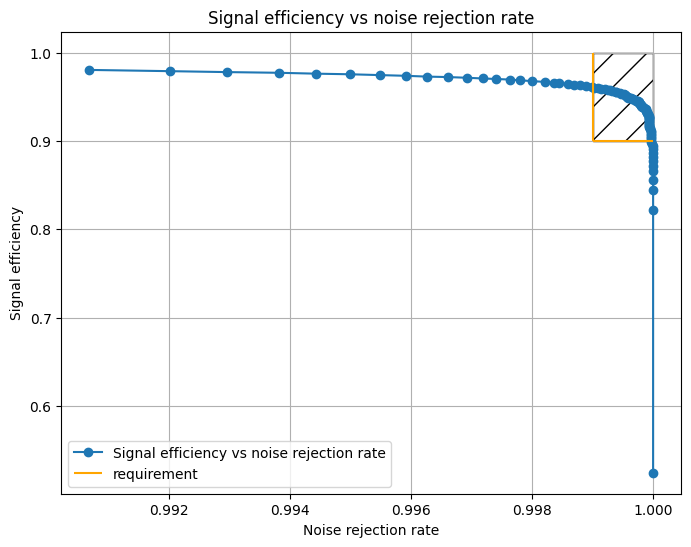

In [128]:
plt.figure(figsize=(8, 6))
plt.plot(specificities, sensitivities, marker='o', label='Signal efficiency vs noise rejection rate')
plt.hlines(0.9, 0.999, 1, colors="orange", label="requirement")
plt.vlines(0.999, 0.9, 1, colors="orange")
plt.fill_between([0.999, 1], [0.9, 0.9], [1,1], facecolor="none", hatch="/")
plt.ylabel('Signal efficiency')
plt.xlabel('Noise rejection rate')
plt.title('Signal efficiency vs noise rejection rate')
plt.grid(True)
plt.legend()
plt.show()

Still within the requirements! I can easily extract which thresholds fullfill this but it is not a part of the exercise. I think it is fair to keep some margin to the requirement, my model is still very small.

In [130]:
flops=get_flops(model)
print(flops)
print(f"Calculation time is approximately {flops/(6463)} nanoseconds")

2811
Calculation time is approximately 0.4349373356026613 nanoseconds
